In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [7]:
class DifferentialQuantity(object):
    def __init__(self, id, eq):
        self.id = id
        self.eq = eq
        self.is_defined = False
        self.derivatives = []

    def d(self,grade):
        if not self.is_defined:
            raise Exception("Quantity is not yet defined.")
        if grade > len(self.derivatives):
            raise Exception("Requested derivative not defined.")
        return self.derivatives[grade]

    def get_id(self):
        return self.id

    def define(self, derivatives):
        self.derivatives = derivatives
        self.is_defined = True

In [8]:
class DifferentialEquation(object):
    def __init__(self):
        self.quantities = []

    def generate_quantities(self, N):
        new_quantities = []
        for i in range(N):
            x = DifferentialQuantity(len(self.quantities)+1,self)
            new_quantities.append(x)
            self.quantities.append(x)
        return new_quantities

    def prepare_quantity_for_recursive_definition(self,quantity, initial_value, initial_value_order, definition_order):
        if not quantity.eq == self:
            raise Exception("The supplied quantity is not part of this differential equation.")
        if quantity.is_defined:
            raise Exception("The quantity is already defined.")
        if initial_value_order >= definition_order:
            raise Exception("The initial value has to be assigned to a lower-order derivative than is being defined.")
        derivatives = []
        for n in range(definition_order):
            dx = None
            if n == initial_value_order:
                dx = tf.Variable(np.reshape(initial_value, np.size(initial_value)), dtype="float64")
            else:
                dx = tf.Variable(np.zeros(np.size(initial_value)))
            derivatives.append(dx)
        quantity.define(derivatives)

    def define_quantity_recursively(self, quantity, definition):
        if not quantity.eq == self:
            raise Exception("The supplied quantity is not part of this differential equation.")

        derivatives = quantity.derivatives
        derivatives.append(definition)
        quantity.define(derivatives)

    def define_quantity(self, quantity, initial_value, initial_value_order, definition_order):
        if not quantity.eq == self:
            raise Exception("The supplied quantity is not part of this differential equation.")

        if initial_value_order >= definition_order:
            raise Exception("The initial value has to be assigned to a lower-order derivative than is being defined.")
        derivatives = []
        for n in range(definition_order):
            dx = None
            if n == initial_value_order:
                dx = tf.Variable(np.reshape(initial_value, np.size(initial_value)), dtype="float64")
            else:
                dx = tf.Variable(np.zeros(np.size(initial_value)))
            derivatives.append(dx)
        quantity.define(derivatives)

        def define_op(definition):
            derivatives.append(definition)
            quantity.define(derivatives)

        return define_op

    def generate_simulate_operation(self, dt):
        # Are all quantities defined?
        for quantity in self.quantities:
            if not quantity.is_defined:
                raise Exception("All Quantities, which belong to this equation, must be defined in order for the simulate operation to be created.")

        updates = []
        for quantity in self.quantities:
            for n in range(len(quantity.derivatives)-1):
                updates.append(quantity.derivatives[n].assign(quantity.derivatives[n] + dt * (quantity.derivatives[n + 1])))
        updates_combined = tf.tuple(updates)
        return updates_combined

Instructions for updating:
Use `tf.global_variables_initializer` instead.


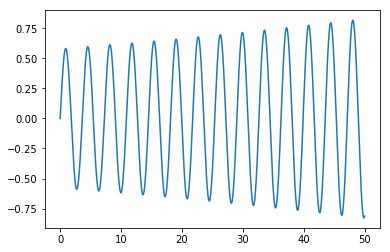

In [11]:
eq = DifferentialEquation()

# Define the quantities involved in the harmonic oscillator
(x, k, m) = eq.generate_quantities(3)

# Define these quantities
eq.define_quantity(k, 3.0, 0, 1)(0.0)
eq.define_quantity(m, 1.0, 0, 1)(0.0)

# The actual equation
eq.define_quantity(x, 1.0, 1, 2)(-k.d(0)*x.d(0)/m.d(0))

# Start tensorflow
sess = tf.Session()
sess.run(tf.initialize_all_variables())
simulate_op = eq.generate_simulate_operation(0.005)


# Simulate and record values
xs = np.zeros(5000)
ts = np.zeros(5000)
for i in range(5000):
    xs[i] = sess.run(x.d(0))
    if i < 4999:
        sess.run(simulate_op)
        sess.run(simulate_op)
        ts[i+1] = ts[i] + 0.01

plt.plot(ts,xs)
plt.show()